In [27]:
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

import geopandas as gpd

In [706]:
df=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\planning_applications.gpkg')

### Creating new bedrooms described variables 

In [707]:
df_bed=df[[ i for i in df.columns if 'bed' in i or 'studio' in i]]
df_bed.head()

,one_bed_units,two_bed_units,three_bed_units,four_plus_bed_units,studio_units
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [708]:
df_bed.isnull().sum()+(df_bed==0).sum()

one_bed_units           58
two_bed_units           13
three_bed_units         90
four_plus_bed_units    108
studio_units           111
dtype: int64

In [709]:
df_bed=df_bed[df_bed.isnull().sum(axis=1)!=5]

In [710]:
df_bed.fillna(0, inplace=True)

In [711]:
df_bed['three_more']=df_bed['three_bed_units']+df_bed['four_plus_bed_units']
df_bed['two_more']=df_bed['two_bed_units']+df_bed['three_more']


In [712]:
df_bed['one_bed_units']=df_bed['one_bed_units']+df_bed['studio_units']

### Concatenate dataset with original building  and proposals. Calculation of ratio of both areas

In [713]:
df_orig=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\block_plans_original_buildings.gpkg')

In [714]:
df.drop([ i for i in df.columns if i in df_bed.columns], axis=1, inplace=True)

In [715]:
df=df.join(df_bed)

In [716]:
df['area1']=df.area

In [717]:
df_orig['area2']=df_orig.area

(array([43., 44., 20.,  8.,  2.,  1.,  2.,  0.,  0.,  1.]),
 array([6.8625000e-01, 7.5644270e+01, 1.5060229e+02, 2.2556031e+02,
        3.0051833e+02, 3.7547635e+02, 4.5043437e+02, 5.2539239e+02,
        6.0035041e+02, 6.7530843e+02, 7.5026645e+02]),
 <a list of 10 Patch objects>)

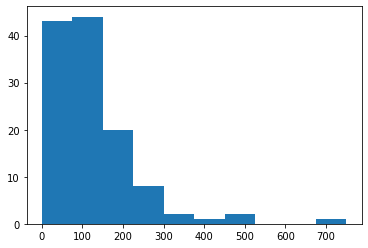

In [718]:
plt.hist(df_orig['area2'])

(array([11., 40., 31., 14.,  9.,  1.,  1.,  2.,  1.,  3.]),
 array([ 88.24199777, 167.58502697, 246.92805616, 326.27108535,
        405.61411455, 484.95714374, 564.30017293, 643.64320213,
        722.98623132, 802.32926051, 881.67228971]),
 <a list of 10 Patch objects>)

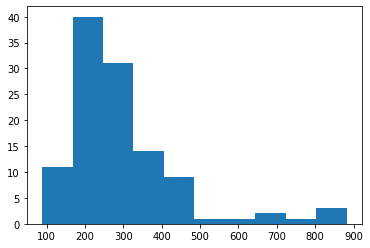

In [719]:
plt.hist(df['area1'])

In [720]:
df_joined=gpd.sjoin(left_df=df_orig, right_df=df, op='intersects')
df_joined['area1/area2']=df_joined['area1']/df_joined['area2']

C:\Users\Intra24\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [721]:
print('3 apps were lost - ', df_joined['planning_application'].nunique())

3 apps were lost -  110


In [722]:
df_joined['area2']

2      222.100950
3      179.004183
4      253.683995
4      253.683995
5      210.317871
          ...    
118     82.637500
118     82.637500
118     82.637500
119    135.473667
119    135.473667
Name: area2, Length: 162, dtype: float64

In [723]:
df_joined=df_joined.merge(df[['planning_application','geometry']], on='planning_application', how='inner').rename(columns={'geometry_x':'geom_original','geometry_y':'geom_proposed'})
df_joined=gpd.GeoDataFrame(df_joined, crs={'epsg':'27700'}, geometry='geom_proposed')
df_joined.area

0      313.824402
1      318.270177
2      356.178932
3      361.439271
4      325.165340
          ...    
157    191.338884
158    226.916897
159    259.509510
160    243.732103
161    267.782434
Length: 162, dtype: float64

In [724]:
df_joined['area1'].median()

278.37227582734135

In [725]:
df_joined['area2'].median()

110.70552500014111

### Concatinate dataset with land area

In [726]:
df_land=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\Bromley\Land_Registry_Cadastral_Parcels.gml')

In [727]:
df_joined['inspire_ids'].apply(lambda x: len(x)>8).sum()

18

In [728]:
df_joined['inspire_1']=''
df_joined['inspire_2']=''
#df_joined[['inspire_1','inspire_2']]=df_joined['inspire_ids'].apply(lambda x: [None,x] if len(x)==8 else x.split('|'))

In [729]:
df_joined['inspire_1']=df_joined['inspire_ids'].apply(lambda x: x if len(x)==8 else x.split('|')[0])
df_joined['inspire_2']=df_joined['inspire_ids'].apply(lambda x: None if len(x)==8 else x.split('|')[1])                                  

df_land['land_area']=df_land.area

df_land['INSPIREID']=df_land['INSPIREID'].astype(str)

In [730]:
df_joined_land1=df_joined.merge(df_land[['INSPIREID','geometry','land_area']], how='inner', left_on='inspire_1',right_on='INSPIREID')
df_joined_land1.rename(columns={'geometry':'geometry_land1'},inplace=True)
df_joined_land2=df_joined_land1.merge(df_land[['INSPIREID','geometry','land_area']], how='left', left_on='inspire_2',right_on='INSPIREID')
df_joined_land2.rename(columns={'geometry':'geometry_land2'},inplace=True)

In [731]:
print ( '10 rows were lost. Finally',df_joined_land1['planning_application'].nunique())

10 rows were lost. Finally 102


In [614]:
df_joined_land2#.columns#[['geom_original','geom_proposed','geometry', 'geometry_y']]

,geom_original,area2,index_right,planning_application,max_height,parking_spaces,has_underground_parking,on_highstreet,postcode,status,...,area1/area2,geom_proposed,inspire_1,inspire_2,INSPIREID_x,geometry_land1,land_area_x,INSPIREID_y,geometry_land2,land_area_y
0,"MULTIPOLYGON (((543130.000 169379.300, 543138....",222.100950,0,18/04199/OUT,NaN,11,False,False,BR1 2AP,approved,...,1.412981,"MULTIPOLYGON (((543120.791 169400.554, 543120....",40879904,None,40879904,"POLYGON ((543101.530 169375.566, 543101.844 16...",2624.275593,NaN,None,NaN
1,"MULTIPOLYGON (((542476.420 168909.280, 542472....",179.004183,1,16/04099/FULL1,8.802,8,None,False,BR1 2AT,appeal_dismissed,...,1.778004,"MULTIPOLYGON (((542465.938 168905.990, 542467....",39022637,None,39022637,"POLYGON ((542462.650 168918.750, 542464.250 16...",1616.181000,NaN,None,NaN
2,"MULTIPOLYGON (((542794.969 168934.316, 542805....",253.683995,2,16/05875/FULL1,9.190,13,None,None,BR1 2AY,approved,...,1.404026,"MULTIPOLYGON (((542796.140 168936.470, 542796....",53133601,None,53133601,"POLYGON ((542775.700 168955.000, 542778.379 16...",1888.438233,NaN,None,NaN
3,"MULTIPOLYGON (((542794.969 168934.316, 542805....",253.683995,3,16/03597/FULL1,9.730,13,None,None,BR1 2AY,refused,...,1.424762,"MULTIPOLYGON (((542795.097 168935.066, 542795....",53133601,None,53133601,"POLYGON ((542775.700 168955.000, 542778.379 16...",1888.438233,NaN,None,NaN
4,"MULTIPOLYGON (((542957.083 169031.454, 542968....",210.317871,4,15/04152/FULL1,9.710,9,None,None,BR1 2BE,appeal_allowed,...,1.546066,"MULTIPOLYGON (((542963.861 169032.317, 542959....",59732233,None,59732233,"POLYGON ((542960.550 168994.950, 542963.180 16...",1688.505556,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,"MULTIPOLYGON (((534824.950 171036.100, 534831....",82.637500,108,18/01228/FULL1,9.000,5,False,None,SE26 6UG,approved,...,2.315400,"MULTIPOLYGON (((534828.450 171040.462, 534835....",37950806,None,37950806,"POLYGON ((534825.300 171018.700, 534825.850 17...",667.183125,NaN,None,NaN
148,"MULTIPOLYGON (((534824.950 171036.100, 534831....",82.637500,109,17/05106/FULL1,9.000,5,False,None,SE26 6UG,refused,...,2.745931,"MULTIPOLYGON (((534828.044 171040.741, 534839....",37950806,None,37950806,"POLYGON ((534825.300 171018.700, 534825.850 17...",667.183125,NaN,None,NaN
149,"MULTIPOLYGON (((534824.950 171036.100, 534831....",82.637500,110,17/01181/FULL1,12.000,4,False,None,SE26 6UG,refused,...,3.140336,"MULTIPOLYGON (((534825.135 171035.399, 534837....",37950806,None,37950806,"POLYGON ((534825.300 171018.700, 534825.850 17...",667.183125,NaN,None,NaN
150,"MULTIPOLYGON (((534786.964 171095.829, 534792....",135.473667,111,17/02629/FULL1,7.490,3,False,None,SE26 6UH,appeal_dismissed,...,1.799111,"MULTIPOLYGON (((534773.969 171102.707, 534776....",37935591,None,37935591,"POLYGON ((534782.949 171087.850, 534787.000 17...",715.387425,NaN,None,NaN


In [732]:
df_joined_land2['total_geometry']=df_joined_land2[['geometry_land1','geometry_land2']].apply(lambda x:x['geometry_land1'] if pd.isnull(x['geometry_land2'])
                                                                                              else x['geometry_land2'], axis=1  )
# df_joined_land2.loc[0,'geometry_land1'].union(df_joined_land2.loc[0,'geometry_land2'])

In [733]:
df_joined_land2['total_land_area']=df_joined_land2['land_area_x']+df_joined_land2['land_area_y'].fillna(0)                                                                                                                             

(array([88., 45., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([  188.0725   ,  1391.1534504,  2594.2344008,  3797.3153512,
         5000.3963016,  6203.477252 ,  7406.5582024,  8609.6391528,
         9812.7201032, 11015.8010536, 12218.882004 ]),
 <a list of 10 Patch objects>)

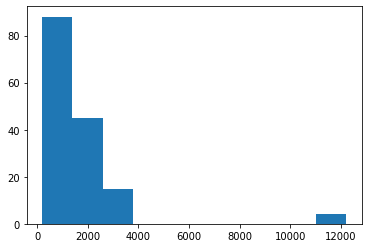

In [734]:
plt.hist(df_joined_land2['total_land_area'])

(array([71., 46., 21.,  4.,  1.,  5.,  2.,  0.,  1.,  1.]),
 array([0.00152457, 0.08881334, 0.1761021 , 0.26339087, 0.35067963,
        0.4379684 , 0.52525716, 0.61254593, 0.69983469, 0.78712346,
        0.87441222]),
 <a list of 10 Patch objects>)

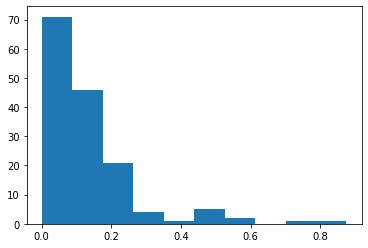

In [735]:
plt.hist(df_joined_land2['area2']/df_joined_land2['total_land_area'])

In [736]:
df_joined_land2['ratio_proposed_land']=df_joined_land2['area1']/df_joined_land2['total_land_area']

In [737]:
df_joined_land2.rename(columns={'area1/area2':'ratio_proposed_original'}, inplace=True)

### Processing of neighbors height

In [738]:
df_height=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\height2017\height2017\bromley_neighbour.shp')

In [739]:
df_joined_land2.columns

Index(['geom_original', 'area2', 'index_right', 'planning_application',
       'max_height', 'parking_spaces', 'has_underground_parking',
       'on_highstreet', 'postcode', 'status', 'address', 'town', 'inspire_ids',
       'on_corner', 'rejected_size', 'rejected_neighbour_effect',
       'rejected_living_conditions', 'rejected_parking',
       'rejected_local_character', 'units', 'one_bed_units', 'two_bed_units',
       'three_bed_units', 'four_plus_bed_units', 'studio_units', 'three_more',
       'two_more', 'area1', 'ratio_proposed_original', 'geom_proposed',
       'inspire_1', 'inspire_2', 'INSPIREID_x', 'geometry_land1',
       'land_area_x', 'INSPIREID_y', 'geometry_land2', 'land_area_y',
       'total_geometry', 'total_land_area', 'ratio_proposed_land'],
      dtype='object')

In [740]:
df_joined_land2.drop(['land_area_x','geometry_land2','land_area_y'], axis=1, inplace=True)

In [741]:
cols_height=['FID_Bromle', 'OBJECTID', 'os_topo_to', 'os_topo_ve', 'bha_proces',
       'tileref', 'abshmin', 'absh2', 'abshmax', 'relh2', 'relhmax',
       'bha_conf', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'FID_brom_1',
       'fid_', 'planning_a', 'BUFF_DIST', 'ORIG_FID', 'geometry']
df_wth_height=df_joined_land2.merge(df_height[cols_height],left_on ='planning_application', right_on='planning_a',how='left')
df_wth_height.columns

Index(['geom_original', 'area2', 'index_right', 'planning_application',
       'max_height', 'parking_spaces', 'has_underground_parking',
       'on_highstreet', 'postcode', 'status', 'address', 'town', 'inspire_ids',
       'on_corner', 'rejected_size', 'rejected_neighbour_effect',
       'rejected_living_conditions', 'rejected_parking',
       'rejected_local_character', 'units', 'one_bed_units', 'two_bed_units',
       'three_bed_units', 'four_plus_bed_units', 'studio_units', 'three_more',
       'two_more', 'area1', 'ratio_proposed_original', 'geom_proposed',
       'inspire_1', 'inspire_2', 'INSPIREID_x', 'geometry_land1',
       'INSPIREID_y', 'total_geometry', 'total_land_area',
       'ratio_proposed_land', 'FID_Bromle', 'OBJECTID', 'os_topo_to',
       'os_topo_ve', 'bha_proces', 'tileref', 'abshmin', 'absh2', 'abshmax',
       'relh2', 'relhmax', 'bha_conf', 'Shape_Leng', 'Shape_Le_1',
       'Shape_Area', 'FID_brom_1', 'fid_', 'planning_a', 'BUFF_DIST',
       'ORIG_FID', 'g

In [742]:
df_wth_height=gpd.GeoDataFrame(df_wth_height, geometry='geometry', crs={'epsg':'27700'})

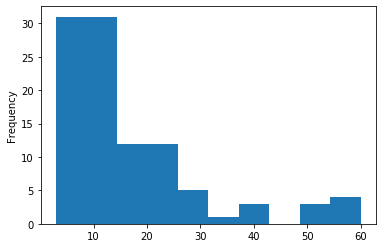

In [743]:
# Histogram of number of building with square more than 50. We check that for every application there is at least a one building with bigger area
df_wth_height.groupby('planning_a')['Shape_Area'].apply(lambda x: sum(x>50)).plot(kind='hist')

In [744]:
# Identifications of the building's area among  its neighbors
for  ind,row in df_wth_height.iterrows():
    df_wth_height.ix[ind,'flag_same']=(row['total_geometry'].intersects(row['geometry']))

C:\Users\Intra24\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [637]:
df_wth_height.groupby('planning_a')['flag_same'].sum().value_counts()

2.0     33
3.0     13
4.0     12
1.0     11
8.0      4
6.0      4
18.0     3
20.0     3
10.0     3
0.0      3
9.0      3
40.0     2
15.0     2
30.0     2
5.0      1
12.0     1
11.0     1
36.0     1
Name: flag_same, dtype: int64

In [745]:
df_height['planning_a'].nunique()

113

In [746]:
df_only_neigbors=df_wth_height[df_wth_height['flag_same']==False]

In [747]:
df_only_neigbors.columns

Index(['geom_original', 'area2', 'index_right', 'planning_application',
       'max_height', 'parking_spaces', 'has_underground_parking',
       'on_highstreet', 'postcode', 'status', 'address', 'town', 'inspire_ids',
       'on_corner', 'rejected_size', 'rejected_neighbour_effect',
       'rejected_living_conditions', 'rejected_parking',
       'rejected_local_character', 'units', 'one_bed_units', 'two_bed_units',
       'three_bed_units', 'four_plus_bed_units', 'studio_units', 'three_more',
       'two_more', 'area1', 'ratio_proposed_original', 'geom_proposed',
       'inspire_1', 'inspire_2', 'INSPIREID_x', 'geometry_land1',
       'INSPIREID_y', 'total_geometry', 'total_land_area',
       'ratio_proposed_land', 'FID_Bromle', 'OBJECTID', 'os_topo_to',
       'os_topo_ve', 'bha_proces', 'tileref', 'abshmin', 'absh2', 'abshmax',
       'relh2', 'relhmax', 'bha_conf', 'Shape_Leng', 'Shape_Le_1',
       'Shape_Area', 'FID_brom_1', 'fid_', 'planning_a', 'BUFF_DIST',
       'ORIG_FID', 'g

In [748]:
df_only_neigbors['neigb_maxh']=df_only_neigbors.groupby('planning_application')['relhmax'].transform('max')

C:\Users\Intra24\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([ 309., 1699.,  887.,  526.,  371.,  114.,   36.,   83.,   32.,
         115.]), array([ 88.24199777, 167.58502697, 246.92805616, 326.27108535,
        405.61411455, 484.95714374, 564.30017293, 643.64320213,
        722.98623132, 802.32926051, 881.67228971]), <a list of 10 Patch objects>)

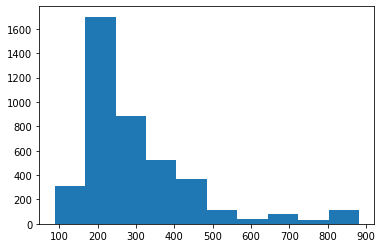

In [634]:
plt.hist(df_only_neigbors['area1'])

In [749]:
# We calculate median only considering buildings whose area is bigger then 80% of min value of proposed buildings.
# By doing so we tend to remove small constructions
min_shape_area=df_only_neigbors['area1'].min()*0.8

In [50]:
# ss=StandardScaler()

# df_bed=pd.DataFrame(ss.fit_transform(df_bed.values), columns=df_bed.columns)

In [750]:
df_only_neigbors[df_only_neigbors['Shape_Area']>min_shape_area].groupby('planning_application')['relhmax'].median()

planning_application
10/02964/FULL1    13.80
12/02049/OUT      12.15
13/02693/FULL1     8.30
13/03044/FULL1     9.50
13/04067/FULL1    12.05
                  ...  
19/01502/OUT       9.50
19/01537/FULL1    10.70
19/01805/FULL1     8.80
19/02756/FULL1    10.10
19/03508/FULL1    15.50
Name: relhmax, Length: 102, dtype: float64

In [751]:
df_only_neigbors1=df_only_neigbors.set_index('planning_application').join(df_only_neigbors[df_only_neigbors['Shape_Area']>min_shape_area].groupby('planning_application')['relhmax'].agg({'neighbor_med':'median'}))

C:\Users\Intra24\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [752]:
fin_cols=[ 'area2',  'max_height', 'parking_spaces',
       'has_underground_parking', 'on_highstreet',   'units',
       'one_bed_units', 'two_bed_units', 'three_bed_units',
       'four_plus_bed_units', 'studio_units', 'three_more', 'two_more',
       'area1', 'ratio_proposed_original',  'total_land_area',  'ratio_proposed_land',
        'neigb_maxh', 'neighbor_med', 'geom_proposed', 'geom_original']
df_fin=df_only_neigbors1[fin_cols]

In [755]:
df_fin['rank']=df_fin.groupby('planning_application')['ratio_proposed_land'].transform(lambda x: x.rank(method='first'))
df_fin=df_fin[df_fin['rank']==1]

C:\Users\Intra24\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [756]:
df_fin.shape

(102, 22)

In [757]:
df_fin.isnull().mean()

area2                      0.000000
max_height                 0.019608
parking_spaces             0.000000
has_underground_parking    0.058824
on_highstreet              0.862745
units                      0.000000
one_bed_units              0.049020
two_bed_units              0.049020
three_bed_units            0.049020
four_plus_bed_units        0.049020
studio_units               0.049020
three_more                 0.049020
two_more                   0.049020
area1                      0.000000
ratio_proposed_original    0.000000
total_land_area            0.000000
ratio_proposed_land        0.000000
neigb_maxh                 0.000000
neighbor_med               0.000000
geom_proposed              0.000000
geom_original              0.000000
rank                       0.000000
dtype: float64

In [700]:
df_fin.columns

Index(['area2', 'max_height', 'parking_spaces', 'has_underground_parking',
       'on_highstreet', 'units', 'one_bed_units', 'two_bed_units',
       'three_bed_units', 'four_plus_bed_units', 'studio_units', 'three_more',
       'two_more', 'area1', 'ratio_proposed_original', 'total_land_area',
       'ratio_proposed_land', 'neigb_maxh', 'neighbor_med', 'geom_proposed',
       'geom_original', 'rank'],
      dtype='object')

In [758]:
# drop if more than 50%
df_fin.drop(['on_highstreet'], axis=1, inplace=True)

In [759]:
df_fin1=df_fin.drop(df_fin.isnull().sum(axis=1)[df_fin[features].isnull().mean(axis=1)>=0.4].index)


In [760]:
df_fin1.isnull().sum()

area2                      0
max_height                 1
parking_spaces             0
has_underground_parking    2
units                      0
one_bed_units              0
two_bed_units              0
three_bed_units            0
four_plus_bed_units        0
studio_units               0
three_more                 0
two_more                   0
area1                      0
ratio_proposed_original    0
total_land_area            0
ratio_proposed_land        0
neigb_maxh                 0
neighbor_med               0
geom_proposed              0
geom_original              0
rank                       0
dtype: int64

In [761]:
df_fin1['max_height'].fillna(df_fin1['max_height'].mean(), inplace=True)

df_fin1['has_underground_parking'].fillna(0, inplace=True)

In [685]:
df_fin1.columns

Index(['area2', 'max_height', 'parking_spaces', 'has_underground_parking',
       'on_highstreet', 'status', 'on_corner', 'rejected_size',
       'rejected_neighbour_effect', 'rejected_living_conditions',
       'rejected_parking', 'rejected_local_character', 'units',
       'one_bed_units', 'two_bed_units', 'three_bed_units',
       'four_plus_bed_units', 'studio_units', 'three_more', 'two_more',
       'area1', 'ratio_proposed_original', 'total_land_area',
       'ratio_proposed_land', 'neigb_maxh', 'neighbor_med', 'geom_proposed',
       'geom_original', 'rank'],
      dtype='object')

In [281]:
df_br=pd.read_csv('bromley_cleaned.csv')

In [549]:
df_br.columns

Index(['fid_', 'planning_a', 'max_height', 'parking_sp', 'one_bed_un',
       'two_bed_un', 'three_bed_', 'four_plus_', 'has_underg', 'studio_uni',
       'on_highstr', 'postcode', 'status', 'address', 'town', 'inspire_id',
       'on_corner', 'rejected_s', 'rejected_n', 'rejected_l', 'rejected_p',
       'rejected_1', 'units', 'F_AREA', 'BUFF_DIST', 'ORIG_FID', 'geometry',
       'parking_per_unit'],
      dtype='object')

In [762]:
cols=[ 'planning_a', 'parking_sp', 'has_underg','parking_per_unit', 'status', 
       'on_corner', 'rejected_s', 'rejected_n', 'rejected_l', 'rejected_p',
       'rejected_1']

In [763]:
df_fin1=df_fin1.merge(df_br[cols], how='inner', left_on='planning_application', right_on='planning_a')

In [768]:
df_fin1=gpd.GeoDataFrame(df_fin1, geometry='geom_proposed', crs={'epsg':27700})

In [376]:
df_dens=gpd.read_file('Bromley density/Bromley density/bromley pop des.shp')

In [680]:
df_dens.head()

,area_code,area_name,census_geo,all_reside,area_ha,density,Shape_Leng,Shape_Area,geometry
0,E01001602,Greenwich 031C,lsoa,1873,25.69,72.9,3929.634465,2.569693e+05,"POLYGON ((543092.339 171947.292, 543084.650 17..."
1,E01001603,Greenwich 031D,lsoa,1655,21.02,78.7,2682.461088,2.102819e+05,"MULTIPOLYGON (((543473.334 171953.973, 543471...."
2,E01000694,Bromley 007C,lsoa,1627,100.87,16.1,5306.785792,1.008685e+06,"MULTIPOLYGON (((542838.021 170319.714, 542831...."
3,E01000781,Bromley 001C,lsoa,1445,17.20,84.0,2348.875176,1.720140e+05,"POLYGON ((542526.624 172297.874, 542525.500 17..."
4,E01000782,Bromley 001D,lsoa,1441,28.35,50.8,3309.046906,2.834255e+05,"POLYGON ((542056.334 172233.608, 542056.350 17..."


In [769]:
df_dens1=gpd.sjoin(left_df=df_fin1, right_df=df_dens, op='within')

C:\Users\Intra24\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'epsg': 27700} != {'init': 'epsg:27700'})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Intra24\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [770]:
df_dens1.columns

Index(['area2', 'max_height', 'parking_spaces', 'has_underground_parking',
       'units', 'one_bed_units', 'two_bed_units', 'three_bed_units',
       'four_plus_bed_units', 'studio_units', 'three_more', 'two_more',
       'area1', 'ratio_proposed_original', 'total_land_area',
       'ratio_proposed_land', 'neigb_maxh', 'neighbor_med', 'geom_proposed',
       'geom_original', 'rank', 'planning_a', 'parking_sp', 'has_underg',
       'parking_per_unit', 'status', 'on_corner', 'rejected_s', 'rejected_n',
       'rejected_l', 'rejected_p', 'rejected_1', 'index_right', 'area_code',
       'area_name', 'census_geo', 'all_reside', 'area_ha', 'density',
       'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [771]:
# For applications not joined at first attempt we try op='intersects'
d_rest=gpd.GeoDataFrame(df_fin1.join(df_dens1[df_dens1.columns[-5:]], how='left'),geometry='geom_proposed', crs={'epsg':'27700'})
d_rest=d_rest[pd.isnull(d_rest['density'])][d_rest.columns[:-5]]
d_rest

,area2,max_height,parking_spaces,has_underground_parking,units,one_bed_units,two_bed_units,three_bed_units,four_plus_bed_units,studio_units,...,parking_sp,has_underg,parking_per_unit,status,on_corner,rejected_s,rejected_n,rejected_l,rejected_p,rejected_1
1,524.782500,10.90,8,False,10,0.0,8.0,0.0,0.0,0.0,...,8,0,0.80,1,0,0,0,0,0,0
2,3.701250,8.57,12,False,8,0.0,0.0,8.0,0.0,0.0,...,12,0,1.50,0,0,1,1,0,1,1
6,231.494113,10.60,9,False,9,0.0,9.0,0.0,0.0,0.0,...,9,0,1.00,1,1,0,0,0,0,0
15,482.834705,16.00,24,False,30,9.0,20.0,0.0,0.0,0.0,...,24,0,0.80,1,0,0,0,0,0,0
30,237.243987,8.78,6,False,8,1.0,4.0,1.0,0.0,0.0,...,6,0,0.75,1,0,0,0,0,0,0
48,59.867959,12.88,4,False,7,6.0,1.0,0.0,0.0,0.0,...,4,0,0.57,0,0,1,1,0,1,0
64,132.514075,11.31,0,True,9,0.0,9.0,0.0,0.0,0.0,...,0,1,0.00,1,1,0,0,0,0,0
67,192.875827,12.70,2,False,7,0.0,6.0,0.0,0.0,0.0,...,2,0,0.29,0,0,1,0,1,0,0
81,109.345350,12.68,0,False,9,4.0,5.0,0.0,0.0,0.0,...,0,0,0.00,1,0,0,0,0,0,0
83,192.875827,11.60,2,False,6,1.0,4.0,0.0,0.0,0.0,...,2,0,0.33,0,0,1,1,0,0,0


In [772]:
# Overlay datasets and leave only observations where intersected area makes up more than 50% of building's area
d_rest['geom_proposed_copy']=d_rest['geom_proposed']
df_over=gpd.overlay(d_rest,df_dens, how='intersection')
df_over=df_over[df_over.area/df_over['area1']>0.5]

In [556]:
df_over.columns

Index(['area2', 'max_height', 'parking_spaces', 'has_underground_parking',
       'on_highstreet', 'postcode', 'status', 'address', 'town', 'inspire_ids',
       'on_corner', 'rejected_size', 'rejected_neighbour_effect',
       'rejected_living_conditions', 'rejected_parking',
       'rejected_local_character', 'units', 'one_bed_units', 'two_bed_units',
       'three_bed_units', 'four_plus_bed_units', 'studio_units', 'three_more',
       'two_more', 'area1', 'ratio_proposed_original', 'total_land_area',
       'ratio_proposed_land', 'neigb_maxh', 'neighbor_med', 'geom_original',
       'rank', 'planning_a', 'parking_sp', 'has_underg', 'parking_per_unit',
       'geom_proposed_copy', 'area_code', 'area_name', 'census_geo',
       'all_reside', 'area_ha', 'density', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [773]:
df_over.rename(columns={'geom_proposed_copy':'geom_proposed'}, inplace=True)

In [774]:
df_dens1.drop('index_right', axis=1, inplace=True)

In [775]:
df_dens1.columns

Index(['area2', 'max_height', 'parking_spaces', 'has_underground_parking',
       'units', 'one_bed_units', 'two_bed_units', 'three_bed_units',
       'four_plus_bed_units', 'studio_units', 'three_more', 'two_more',
       'area1', 'ratio_proposed_original', 'total_land_area',
       'ratio_proposed_land', 'neigb_maxh', 'neighbor_med', 'geom_proposed',
       'geom_original', 'rank', 'planning_a', 'parking_sp', 'has_underg',
       'parking_per_unit', 'status', 'on_corner', 'rejected_s', 'rejected_n',
       'rejected_l', 'rejected_p', 'rejected_1', 'area_code', 'area_name',
       'census_geo', 'all_reside', 'area_ha', 'density', 'Shape_Leng',
       'Shape_Area'],
      dtype='object')

In [776]:
df_over=gpd.GeoDataFrame(df_over, geometry='geom_proposed')

In [447]:
# Check if there are columns with different types in two datasets
# dic_type=dict([(i,j) for i,j in df_dens1.dtypes.items() ])

# [(i,j) for i,j in df_over[df_dens1.columns].dtypes.items() if dic_type[i]!=j]

In [777]:
df_dens_fin=pd.concat([df_dens1, df_over[df_dens1.columns]], axis=0, ignore_index=True)

In [517]:
#converting reasons for rejection values from TRUE/FALSE to 1/0
# rej_cols=[i for i in df_dens_fin.columns if 'reject' in i or 'on_corner' in i]
# for i in rej_cols:
#     df_dens_fin[i] = df_dens_fin[i].astype(bool)*1

In [778]:
df_dens_fin.describe()

,area2,max_height,parking_spaces,one_bed_units,two_bed_units,three_bed_units,four_plus_bed_units,studio_units,three_more,two_more,...,rejected_s,rejected_n,rejected_l,rejected_p,rejected_1,all_reside,area_ha,density,Shape_Leng,Shape_Area
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,1.020000e+02
mean,138.052719,10.239447,7.421569,2.166667,5.313725,0.509804,0.264706,0.039216,0.774510,6.088235,...,0.411765,0.303922,0.176471,0.127451,0.068627,1614.068627,57.130686,38.537255,4776.681403,5.712970e+05
std,92.790571,1.801805,8.600525,2.941958,3.709715,1.384104,1.319514,0.278666,1.882209,3.598963,...,0.494583,0.462221,0.383103,0.335124,0.254068,188.384758,50.222014,19.745645,1671.129795,5.022135e+05
min,2.323750,6.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1206.000000,13.610000,3.400000,1875.749139,1.361417e+05
25%,82.789375,8.757500,3.250000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1520.000000,34.290000,23.925000,3739.312264,3.429155e+05
50%,131.004386,10.125000,6.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1612.500000,41.520000,38.500000,4817.138526,4.152668e+05
75%,164.805645,11.832500,9.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.750000,8.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1703.500000,64.390000,46.400000,5306.785792,6.439761e+05
max,524.782500,16.000000,78.000000,17.000000,20.000000,8.000000,8.000000,2.000000,8.000000,20.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2266.000000,460.040000,116.500000,15913.657770,4.600365e+06


In [779]:
df_dens_fin['h_neigb_max']=df_dens_fin['max_height']/df_dens_fin['neigb_maxh']
df_dens_fin['h_neigb_med']=df_dens_fin['max_height']/df_dens_fin['neighbor_med']

In [780]:
df_dens_fin['has_underground_parking']=df_dens_fin['has_underground_parking'].astype(bool)*1

In [781]:
df_dens_fin.shape

(102, 42)

In [786]:
features=['area2', 'max_height', 'parking_spaces', 'has_underground_parking',
       'units', 'one_bed_units', 'two_bed_units','units',
       'three_bed_units', 'four_plus_bed_units', 'studio_units', 'three_more',
       'two_more', 'area1', 'ratio_proposed_original', 'total_land_area', 
       'ratio_proposed_land', 'neigb_maxh', 'neighbor_med']
target_cols=[i for i in df_dens_fin.columns if 'status' in i or 'reject' in i ]

In [ ]:
df_dens_fin

In [787]:
df_dens_fin[features+target_cols].to_csv('df_dens_fin.csv')

In [785]:
df_dens_fin[features]

,area2,max_height,parking_spaces,has_underground_parking,units,one_bed_units,two_bed_units,units,three_bed_units,four_plus_bed_units,studio_units,three_more,two_more,area1,ratio_proposed_original,total_land_area,ratio_proposed_land,neigb_maxh,neighbor_med
0,130.947238,12.00,21,0,21,1.0,18.0,21,2.0,0.0,0.0,2.0,20.0,435.183680,3.323351,1570.891205,0.277030,15.9,13.80
1,224.366138,11.89,10,0,7,0.0,7.0,7,0.0,0.0,0.0,0.0,7.0,272.992036,1.216726,1496.925000,0.182369,16.3,9.50
2,130.947238,12.93,19,0,16,0.0,14.0,16,2.0,0.0,0.0,2.0,16.0,520.568057,3.975403,1570.891205,0.331384,15.9,14.85
3,153.657469,9.00,2,1,8,0.0,3.0,8,5.0,0.0,0.0,5.0,8.0,415.575645,2.704559,1839.866518,0.225873,13.6,12.05
4,165.526533,8.54,3,1,6,0.0,6.0,6,0.0,0.0,0.0,0.0,6.0,367.842239,2.222255,1625.078087,0.226354,13.6,11.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,132.514075,11.31,0,1,9,0.0,9.0,9,0.0,0.0,0.0,0.0,9.0,426.941534,3.221858,1495.366250,0.285510,18.3,11.20
98,192.875827,12.70,2,0,7,0.0,6.0,7,0.0,0.0,0.0,0.0,6.0,198.561816,1.029480,418.836315,0.474080,15.3,10.70
99,192.875827,11.60,2,0,6,1.0,4.0,6,0.0,0.0,0.0,0.0,4.0,208.434921,1.080669,418.836315,0.497652,15.3,10.70
100,109.345350,12.68,0,0,9,4.0,5.0,9,0.0,0.0,0.0,0.0,5.0,164.882796,1.507909,188.072500,0.876698,16.8,16.70


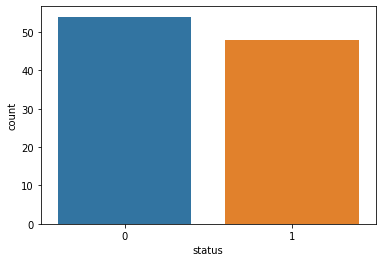

In [788]:
sns.countplot(df_dens_fin.status)

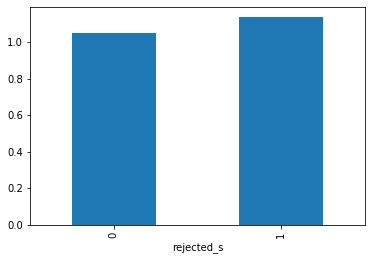

In [577]:
df_dens_fin.groupby('rejected_s')['h_neigb_med'].median().plot(kind='bar')

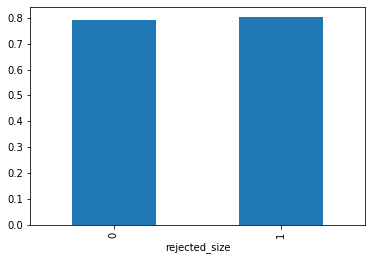

In [533]:
df_dens_fin.groupby('rejected_size')['h_neigb_max'].median().plot(kind='bar')